2.5.0-rc1


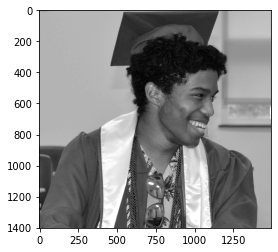

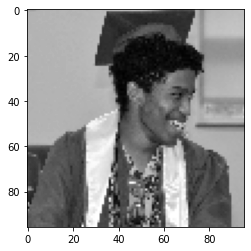

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

trainPath = "train"
testPath = "test"

#names of labels
labels = ["sam", "noel"]
IMG_SIZE = 96 #images will be resized to 96x96 based on arduino code

#Making sure that images are loaded correctly (load first image in dataset)
for x in labels:
    path = os.path.join(trainPath, x)
    count = 0
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        sized_img = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
        plt.imshow(img_array, cmap="gray")
        plt.show()
        plt.imshow(sized_img, cmap="gray")
        plt.show()
        break
    break


In [34]:
#Append labels to images, grey images and automatically make them correct size for train data

train_data = []

for x in labels:
    path = os.path.join(trainPath, x)
    class_num = labels.index(x)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            sized_img = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            train_data.append([sized_img, class_num])
        except Exception as e:
            pass


In [35]:
#Append labels to images, grey images and automatically make them correct size for test data

test_data = []

for x in labels:
    path = os.path.join(testPath, x)
    class_num = labels.index(x)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        sized_img = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
        test_data.append([sized_img, class_num])

In [36]:
#Select random from training data for validation data

num_train_data = len(train_data)
num_test_data = len(test_data)
num_val_data = int(num_train_data * .2)

random.shuffle(train_data)
val_data = train_data[0:int(num_val_data)]



In [37]:
print("Num of training data: ", num_train_data)
print("Num of testing data: ", num_test_data)
print("Num of validation data: ", num_val_data)

#shuffle data around for better training
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

Num of training data:  219
Num of testing data:  38
Num of validation data:  43


In [38]:
XTrain = []
YTrain = []
XVal = []
YVal = []
XTest = []
YTest = []

#Creates NP array with same data; X = data Y = label
for img, label in train_data:
    XTrain.append(img)
    YTrain.append(label)

for img, label in val_data:
    XVal.append(img)
    YVal.append(label)

for img,label in test_data:
    XTest.append(img)
    YTest.append(label)

XTrain = np.array(XTrain).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
YTrain = np.array(YTrain)

XVal = np.array(XVal).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
YVal = np.array(YVal)

XTest = np.array(XTest).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
YTest = np.array(YTest)

In [39]:
#normalize data
XTrain = XTrain / 255
XVal = XVal / 255
XTest = XTest / 255

input_shape=XTrain.shape[1:]
print(input_shape)


(96, 96, 1)


In [40]:
#Create CNN
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(4, 3, strides=(2,2), activation='relu'),
    layers.Conv2D(8, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)),  
    layers.BatchNormalization(), 
    layers.Conv2D(32, 4, activation='relu' ),
    layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)),  
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(len(labels), activation = 'softmax'),
], name="medium_cnn")

model.summary()


Model: "medium_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 47, 47, 4)         40        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 8)         296       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 8)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 8)         32        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 32)          4128      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0

In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [42]:
EPOCHS = 30
history = model.fit(
    XTrain, YTrain, 
    validation_data=(XVal, YVal),  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3))

Epoch 1/30
C:\Users\Sam\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
7/7 [==============================] - 1s 46ms/step - loss: 0.6854 - accuracy: 0.5478 - val_loss: 0.6812 - val_accuracy: 0.5789
Epoch 2/30
7/7 [==============================] - 0s 24ms/step - loss: 0.4610 - accuracy: 0.9315 - val_loss: 0.6711 - val_accuracy: 0.6053
Epoch 3/30
7/7 [==============================] - 0s 26ms/step - loss: 0.3667 - accuracy: 0.9419 - val_loss: 0.6542 - val_accuracy: 0.5789
Epoch 4/30
7/7 [==============================] - 0s 26ms/step - loss: 0.2435 - accuracy: 0.9630 - val_loss: 0.6366 - val_accuracy: 0.6053
Epoch 5/30
7/7 [==============================] - 0s 26ms/step - loss: 0.1678 - accuracy: 0.9606 - val_loss: 

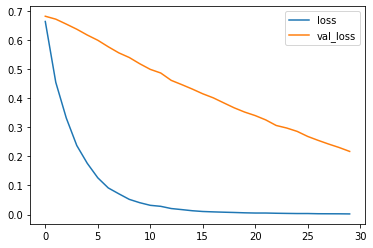

In [43]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [44]:
#Test Accuracy

y_pred = np.argmax(model.predict(XTest), axis=1)
y_true = YTest

print("Pred: ", y_pred)
print("Actual: ", y_true)

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Pred:  [1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1
 1]
Actual:  [0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1
 1]
Test set accuracy: 87%


In [45]:
#Convert to TFLite

converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_quant_model = converter.convert()

frame = 'final_model.tflite'
with open(frame, "wb") as fpo:
    num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

INFO:tensorflow:Assets written to: C:\Users\Sam\AppData\Local\Temp\tmp528ji2ua\assets
INFO:tensorflow:Assets written to: C:\Users\Sam\AppData\Local\Temp\tmp528ji2ua\assets
Wrote 55832 / 55832 bytes to tflite file
